In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib notebook

The best-fit value for the ('forward') slope and intercept are: 2.2399 and 34.0477
The best-fit value for the ('reverse') slope and intercept are: 2.6352 and -49.9429
2.2399208316310926 34.047727757542816
The best-fit value for the slope and intercept are: 2.2399 and 34.0477


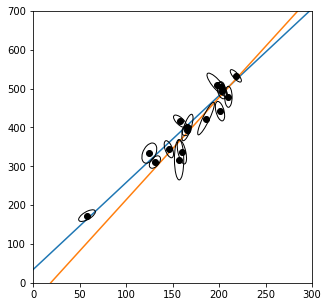

In [2]:
obs_x = np.array([203, 58, 210, 202, 198, 158, 
                165, 201, 157, 131, 166, 160, 
                186, 125, 218, 146])
obs_y = np.array([495, 173, 479, 504, 510, 416, 
                393, 442, 317, 311, 400, 337, 
                423, 334, 533, 344])
sigma_x = np.array([5, 9, 4, 4, 11, 7, 
                    5, 5, 5, 6, 6, 5, 
                    9, 8, 6, 5])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 
                    14, 25, 52, 16, 34, 31, 
                    42, 26, 16, 22])
rho_xy = np.array([-0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 
                    0.90, 0.40, -0.78, -0.56])


def plotData(ax, x, y, xerr, yerr, rhoxy, zorder = 10):
    
    #ax.errorbar(x, y, xerr = sigma_x, yerr = sigma_y, fmt = "o", capsize=3)
    ax.scatter(x, y, color = 'black', zorder = 10)
    for (xx, yy, sx, sy, rxy) in zip(x,y,sigma_x, sigma_y, rho_xy):
        #from here: https://www.unige.ch/sciences/astro/files/5413/8971/4090/2_Segransan_StatClassUnige.pdf
        #also here: http://www.cs.utah.edu/~tch/CS4300/resources/refs/ErrorEllipses.pdf
        #find better reference
        cov = np.array([[ sx**2, rxy*sx*sy],
                        [rxy*sx*sy, sy**2.]])
        w, v  = np.linalg.eig(cov)
        theta = np.arctan(2. * rxy * sx * sy / (sx**2. - sy**2.))/2.
        ax.add_artist(Ellipse((xx, yy), 2.*w[0]**0.5, 2.*w[1]**0.5, \
                              angle = np.rad2deg(theta),\
                              facecolor="none", edgecolor="black", zorder = zorder))
        
f = plt.figure(0, figsize = (5,5))
ax = f.add_subplot(111)

plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#"abominable" forward–reverse fitting procedure
#DON'T DO THIS!
#polyfit with uncertainties on x
p_xy = np.polyfit(obs_x, obs_y, 1, w = 1./sigma_y)
p_xy_eval = np.poly1d(p_xy)
print("The best-fit value for the ('forward') slope and intercept are: {:.4f} and {:.4f}".format(p_xy[0], p_xy[1]))
ax.plot([0,300],p_xy_eval([0,300]),color='C0')

#polyfit with uncertainties on y
p_yx = np.polyfit(obs_y, obs_x, 1, w = 1./sigma_x)
p_yx_eval = np.poly1d(p_yx)
print("The best-fit value for the ('reverse') slope and intercept are: {:.4f} and {:.4f}".format(1./p_yx[0], -p_yx[1]/p_yx[0]))
ax.plot(p_yx_eval([0.,700.]), [0.,700.],color='C1')

#a little bit more thorough (see Adams' problem 2e and notes above)
Y = obs_y.reshape(-1,1)
A = np.vstack((np.ones_like(obs_x), obs_x)).T
C = np.diag(sigma_y**2)

X = np.linalg.inv(A.transpose()@np.linalg.inv(C)@A) @ (A.transpose()@np.linalg.inv(C)@Y)

#from emcee website
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, obs_y)))
print(m_ls,b_ls)

best_fit = np.poly1d(X[::-1,0])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(X[1][0], X[0][0]))

mFreq = X[1][0]
bFreq = X[0][0]


In [3]:
def lnlike(theta, x, y, xerr, yerr, rhoxy):
    
    th, bperp, p_b, lnv_b, y_b = theta
    lnl = 0.
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        v = np.array([[-np.sin(th)], [np.cos(th)]])
        vT = v.transpose()
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Epsilon2 = vT @ S @ v
        lnl -= Delta**2. / (2. * Epsilon2)
    


    return lnl

def lnprior(theta):
    th, bperp, p_b, lnv_b, y_b = theta
    if 0 < np.abs(th) < 2.*np.pi and -200 < bperp < 200 and 0 < p_b < 1.0 and 0 < lnv_b < 20 and -1000 < y_b < 1000:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,  x, y, xerr, yerr, rhoxy)

ndim, nwalkers = 5, 100
pos = [[2.24, 34, 0.2, 5, 0] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

emcee results with 1-sigma uncertainties
 m = 2.2012 +0.1244 -0.1188
 b = 35.7437 +19.5947 -20.1430


Text(0.5,0,'x')

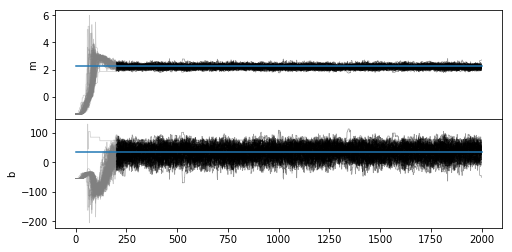

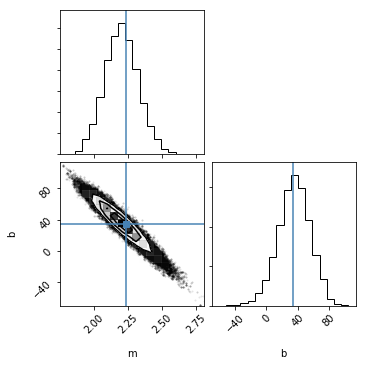

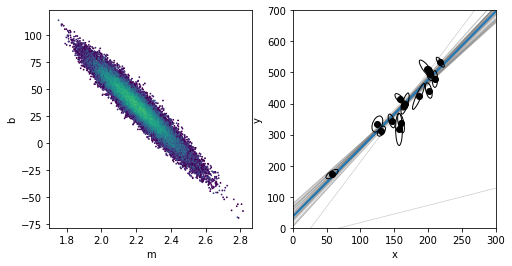

In [5]:
def mFromTh(th):
    return np.tan(th)
def bFromThBp(th, bp):
    return bp/np.cos(th)

nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n m = {:.4f} +{:.4f} -{:.4f}\n b = {:.4f} +{:.4f} -{:.4f}"\
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))


#chains
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,4), sharex = True)
ax1.set_ylabel("m")
ax2.set_ylabel("b")
fig.subplots_adjust(hspace = 0)
xplot = range(nsamples)
ax1.plot([0, nsamples],[mFreq, mFreq], color = 'C0', zorder = 10)
ax2.plot([0, nsamples],[bFreq, bFreq], color = 'C0', zorder = 10)
for w in range(nwalkers - 1):
    th_sample = sampler.chain[w,:nburn,0]
    bp_sample = sampler.chain[w,:nburn,1]
    ax1.plot(xplot[:nburn], mFromTh(th_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[:nburn], bFromThBp(th_sample, bp_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    th_sample = sampler.chain[w,nburn:,0]
    bp_sample = sampler.chain[w,nburn:,1]
    ax1.plot(xplot[nburn:], mFromTh(th_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[nburn:], bFromThBp(th_sample, bp_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)

#corner plot
import corner
corner.corner(samples, labels = ['m','b'], truths = [mFreq, bFreq])


#Adam's plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.hexbin(m_samples, b_samples, gridsize = 250, bins = "log", mincnt = 1)
plotData(ax2, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax2.set_xlim(0,300)
ax2.set_ylim(0,700)


max_prob = np.argmax(sampler.flatlnprobability)
th_max = sampler.flatchain[:,0][max_prob]
bp_max = sampler.flatchain[:,1][max_prob]
m_max = mFromTh(th_max)
b_max = bFromThBp(th_max, bp_max)
ax2.plot([0,300], [b_max + 0*m_max, b_max + 300*m_max], lw = 2, zorder = 2)

ndraw = 50
for rand_draw in np.random.randint(500, len(sampler.flatchain[:,0]), ndraw):
    th_draw = sampler.flatchain[:,0][rand_draw]
    bp_draw = sampler.flatchain[:,1][rand_draw]
    m_draw = mFromTh(th_draw)
    b_draw = bFromThBp(th_draw, bp_draw)
    ax2.plot([0,300], [b_draw + 0*m_draw, b_draw + 300*m_draw],
             color = "0.5", alpha = 0.4, lw = 0.7, zorder = 1)

ax1.set_xlabel("m")
ax1.set_ylabel("b")
ax2.set_ylabel("y")
ax2.set_xlabel("x")